라이브러리

In [39]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau



# 한글 글꼴 경로 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 원하는 한글 글꼴 파일 경로로 수정해주세요
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

데이터셋 설정

In [40]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_training_food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_training_sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_sensor_val_tb.csv")

In [41]:
#자포니카 훈련 데이터 시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

#자포니카 검증 데이터 시계열 변환
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [42]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training_tankAll = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation_tankAll = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

In [43]:
#자포니카 훈련 및 검증 데이터 시계열 변환
japonica_training_tankAll['mea_dt'] = pd.to_datetime(japonica_training_tankAll['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_tankAll['mea_dt'] = pd.to_datetime(japonica_validation_tankAll['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

In [44]:
# 날짜 데이터를 인덱스로 전환
japonica_training_tankAll.set_index('mea_dt', inplace=True)
japonica_validation_tankAll.set_index('mea_dt', inplace=True)

In [45]:
# 인덱스 순으로 데이터를 정렬
japonica_training_tankAll = japonica_training_tankAll.sort_index()
japonica_validation_tankAll = japonica_validation_tankAll.sort_index()

In [46]:
# 자포니카 훈련 및 검증 데이터의 각 탱크 번호
tank = 1
japonica_training_tank = japonica_training_tankAll[japonica_training_tankAll['tank_id']==tank]
japonica_validation_tank = japonica_validation_tankAll[japonica_validation_tankAll['tank_id']==tank]

In [47]:
# 사용할 features 선택
japonica_training_tank_features = japonica_training_tankAll[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation_tank_features = japonica_validation_tankAll[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_tank_features = japonica_training_tank_features.fillna(0)
japonica_validation_tank_features = japonica_validation_tank_features.fillna(0)

In [48]:
# 독립 변수, 종속 변수 분리
japonica_training_tank_features_X = japonica_training_tank_features[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_training_tank_features_y = japonica_training_tank_features[['do_mg']]
japonica_validation_tank_features_X = japonica_validation_tank_features[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation_tank_features_y = japonica_validation_tank_features[['do_mg']]

In [49]:
# LSTM학습을 위해 데이터 reshape를 해야함. reshape를 위해 배열형으로 변환
japonica_training_tank_features_X_reshape = np.asarray(japonica_training_tank_features_X, dtype=np.float64)
japonica_validation_tank_features_X_reshape = np.asarray(japonica_validation_tank_features_X, dtype=np.float64)

# 데이터를 3항으로 reshape. (batch_size, timesteps, features)
# batch_size: 한 번에 모델에 입력되는 샘플의 개수
# timesteps: 입력되는 시퀀스 데이터의 길이(시간축)
# features: 입력되는 데이터의 특성 개수
# 말이 어려우니까 쉽게 쓰면 (얼마 만큼의 샘플을, 시간 당 몇 개씩, 항목이 몇 개인가)
# (-1 : 있는 만큼의 샘플을, 1 : 시간당 1개씩, 8 : 피처는 8개입니다.)
japonica_training_tank_features_X_reshape = japonica_training_tank_features_X_reshape.reshape((-1, 1, 8))
japonica_validation_tank_features_X_reshape = japonica_validation_tank_features_X_reshape.reshape((-1, 1, 8))

In [50]:
# shape확인
nCar = japonica_training_tank_features_X_reshape.shape[0] # 데이터 개수
nVar = japonica_training_tank_features_X_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_tank_features_y.shape[0] # 데이터 개수
nVar = japonica_training_tank_features_y.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = japonica_validation_tank_features_X_reshape.shape[0] # 데이터 개수
nVar = japonica_validation_tank_features_X_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_tank_features_y.shape[0] # 데이터 개수
nVar = japonica_validation_tank_features_y.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1113748 nVar: 1
nCar: 1113748 nVar: 1
nCar: 1113748 nVar: 1
nCar: 1113748 nVar: 1


In [51]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [28]:
# LSTM 모델 생성
model = Sequential()
# 결과값이 128개 -> 64개 -> 32개 -> 1개(회귀)
# input_shape=(timesteps, input_dim)
# timesteps : 시계열 데이터의 시간 스텝 수.
#       예를 들어, 1분 단위로 측정한 센서 데이터가 있다면 timesteps는 60.
# input_dim : 특성(feature)의 수.
model.add(LSTM(128, input_shape=(1, 8), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            70144     
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 132,001
Trainable params: 132,001
Non-trainable params: 0
_________________________________________________________________


In [52]:
model_name = 'test230407-05_lstmJaponicaAll.h5'

In [29]:
checkpoint = ModelCheckpoint('test230407-02_lstmJaponicaNomal.h5_best_model.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.

hist = model.fit(japonica_training_tank_features_X_reshape, japonica_training_tank_features_y, epochs = 200, batch_size = 64, validation_data=(japonica_validation_tank_features_X_reshape, japonica_validation_tank_features_y), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name)

Epoch 1/200
17403/17403 [==============================] - 112s 6ms/step - loss: 3.0730 - mae: 1.3572 - r_squared: 0.2943 - val_loss: 2.7664 - val_mae: 1.2929 - val_r_squared: -2.7605 - lr: 0.0010
Epoch 2/200
17403/17403 [==============================] - 104s 6ms/step - loss: 2.6396 - mae: 1.2634 - r_squared: 0.3919 - val_loss: 2.6899 - val_mae: 1.2752 - val_r_squared: -2.9505 - lr: 0.0010
Epoch 3/200
17403/17403 [==============================] - 106s 6ms/step - loss: 2.5676 - mae: 1.2406 - r_squared: 0.4075 - val_loss: 2.5766 - val_mae: 1.2363 - val_r_squared: -2.6248 - lr: 0.0010
Epoch 4/200
17403/17403 [==============================] - 111s 6ms/step - loss: 2.4908 - mae: 1.2159 - r_squared: 0.4248 - val_loss: 2.4687 - val_mae: 1.2059 - val_r_squared: -2.5375 - lr: 0.0010
Epoch 5/200
17403/17403 [==============================] - 119s 7ms/step - loss: 2.4011 - mae: 1.1858 - r_squared: 0.4449 - val_loss: 2.3999 - val_mae: 1.1790 - val_r_squared: -2.3087 - lr: 0.0010
Epoch 6/200
174

모델 평가

In [53]:
# 모델 평가 함수
def grape(X_test, y_test, X_pred):
    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(X_test.index, y_test, label='actual')  # x축에 년월일, y축에 값
    plt.plot(X_test.index, X_pred, color='red', label='prediction')  # x축에 년월일, y축에 시분
    plt.xlabel('날짜')
    plt.ylabel('DO')
    plt.title('시계열')
    plt.legend(['y_test','X_pred'])
    plt.show()
    
def eva(X_test_shape, y_test):
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test)
    print("MSE // MAE // R-squared ", result)

In [55]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name, custom_objects={'r_squared': r_squared})

[[ 0.06631635 -0.15317158 -1.6713951  ...  0.20278211 -0.01130058
  -1.3656149 ]
 [ 0.02693521 -0.16125733  0.57996315 ...  0.21145384  0.338768
   0.60347384]
 [-0.35209733  0.07576905  0.2829647  ...  0.11100415  0.4331607
   0.18433174]
 ...
 [ 0.01803795 -0.13523749 -0.23797072 ...  0.17994067 -0.05509014
  -0.8993038 ]
 [-0.08356813  0.03627219 -0.65576994 ...  0.08968684 -0.51688755
  -0.13962123]
 [ 0.0186621  -0.01974888 -0.85359275 ...  0.08997519 -0.5548208
  -0.07878602]]


c:\Users\rladn\anaconda3\envs\doRegressor\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


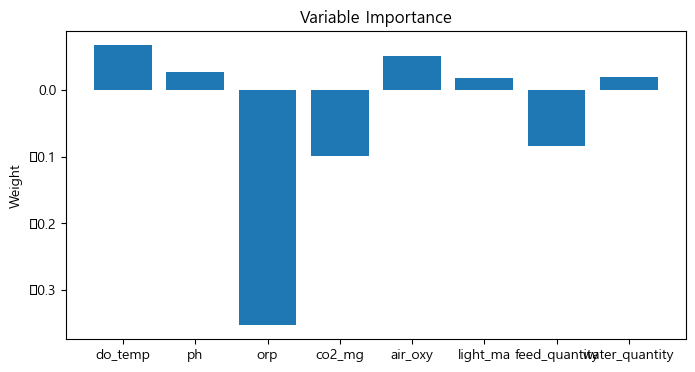

In [56]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(8), weights[:, 0])
ax.set_xticks(range(8))
ax.set_xticklabels(['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [57]:
# japonica_validation_tank_features_X_reshape 검증모델 예측
japonica_validation_tank_features_X_pred = model.predict(japonica_validation_tank_features_X_reshape)

34805/34805 [==============================] - 65s 2ms/step


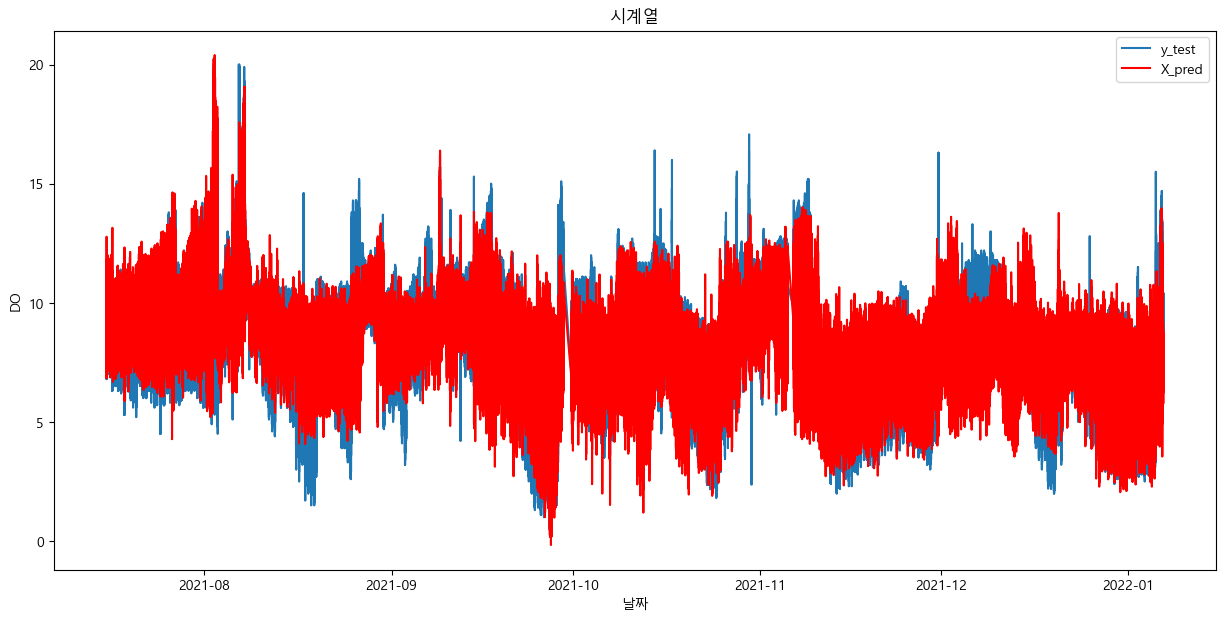

34805/34805 [==============================] - 74s 2ms/step - loss: 1.3248 - mae: 0.8066 - r_squared: -1.0687
MSE // MAE // R-squared  [1.3247915506362915, 0.8066175580024719, -1.068716049194336]


In [59]:
grape(japonica_validation_tank_features_X, japonica_validation_tank_features_y, japonica_validation_tank_features_X_pred)
eva(japonica_validation_tank_features_X_reshape, japonica_validation_tank_features_y)

In [66]:
# 하루 동안의 데이터 추출
one_day_data = japonica_validation_tank.loc['2021-08-27 00:00:00':'2021-08-27 23:59:59']
oneday_X_test = one_day_data[['do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
oneday_y_test = one_day_data[['do_mg']]

oneday_X_test = oneday_X_test.fillna(0)

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 1, 8))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

oneday_pred = model.predict(oneday_X_test_reshape)

nCar: 1440 nVar: 1
nCar: 1440 nVar: 1
45/45 [==============================] - 0s 2ms/step


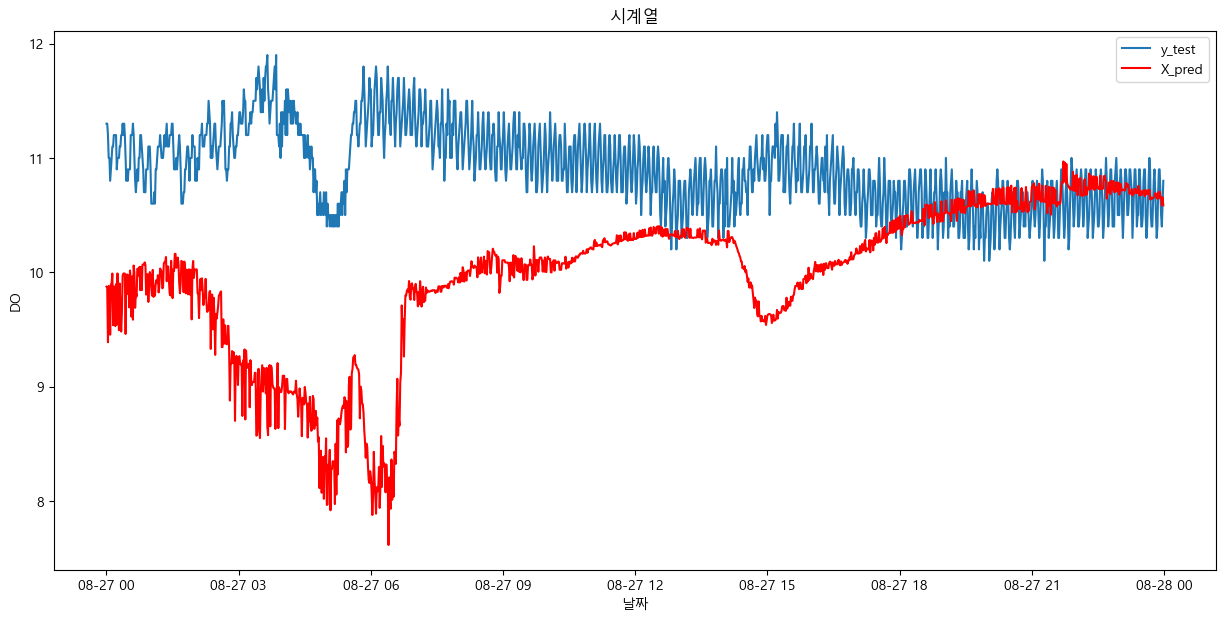

In [67]:
grape(oneday_X_test, oneday_y_test, oneday_pred)

In [37]:
japonica_training_tank['year_month_day'] = japonica_training_tank.index.strftime('%Y-%m-%d')  # 년월일만 추출
japonica_training_tank['hour_minute'] = japonica_training_tank.index.strftime('%H:%M')  # 시분만 추출
japonica_cross_tab_tank = pd.crosstab(index=japonica_training_tank['hour_minute'], columns=japonica_training_tank['year_month_day'], values=japonica_training_tank['do_mg'], aggfunc='sum')

japonica_cross_tab_tank

NameError: name 'japonica_training_tank' is not defined